# 结果展示

In [15]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
import os

from utils import config
from utils.backtest import *

start_date = config.End_Trade_Date.replace("-", "")
end_date = config.End_Test_Date.replace("-", "")

## 数据读取

In [16]:
root_path = os.getcwd()
root_path = os.path.join(root_path, "learn", "trade_file")
print("root_path: ", root_path)

root_path:  /home/david/MF/github/StockRL/learn/trade_file


In [17]:
model_list = ["a2c", "ppo", "td3", "ddpg", "sac"]
path_dict = {}
for model in model_list:
    path_dict[model] = os.path.join(root_path, "account_value_{}.csv".format(model))

In [18]:
account_value_dict = {}
for m in model_list:
    account_value_dict[m] = pd.read_csv(path_dict[m])

## 获取 baseline 的结果

In [19]:
get_baseline_func = lambda: get_baseline(config.SSE_50_INDEX, 
              start=start_date,
              end=end_date)
baseline_csv_file = root_path + os.sep + "baseline_sse50.csv"
baseline_df = get_baseline_from_file(baseline_csv_file, get_baseline_func)

In [20]:
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

Annual return         -0.117414
Cumulative returns    -0.113029
Annual volatility      0.130011
Sharpe ratio          -0.899786
Calmar ratio          -0.547896
Stability              0.847976
Max drawdown          -0.214301
Omega ratio            0.863667
Sortino ratio         -1.275702
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.026249
Daily value at risk   -0.016844
dtype: float64


In [21]:
start_close_value = baseline_df.iloc[0]['close']
baseline_df['processed_close'] = ((baseline_df['close'] - start_close_value)/start_close_value + 1) * 1e+6

In [22]:
baseline_df.head()

,tic,date,open,high,low,close,volume,day,processed_close
0,000016.SH,2023-01-03,2641.4218,2628.6723,2645.9915,2603.7234,30230100.0,1,1.000000e+06
1,000016.SH,2023-01-04,2651.0050,2644.2910,2659.5351,2637.7160,28065521.0,2,1.013055e+06
2,000016.SH,2023-01-05,2700.3082,2670.4576,2705.7388,2668.1451,27714894.0,3,1.024742e+06
3,000016.SH,2023-01-06,2713.6307,2704.2375,2721.9279,2698.9087,28367259.0,4,1.036557e+06
4,000016.SH,2023-01-09,2742.2014,2730.9952,2747.6106,2722.1459,29682897.0,0,1.045482e+06


## 展示最终的结果

In [23]:
data = {
    m: account_value_dict[m]['total_assets'] for m in model_list
}
data['baseline'] = baseline_df['processed_close']
result_account_value = pd.DataFrame(data = data)

In [24]:
result_account_value = result_account_value.iloc[:-1].apply(lambda x : (x - 1e+6)/1e+6)

In [25]:
result_account_value.tail()

,a2c,ppo,td3,ddpg,sac,baseline
236,-0.106875,-0.101935,0.026496,-0.018549,0.019436,-0.135298
237,-0.105782,-0.102986,0.030466,-0.018082,0.021840,-0.130628
238,-0.106963,-0.109398,0.027686,-0.022712,0.018706,-0.133797
239,-0.104019,-0.105763,0.029934,-0.017812,0.024524,-0.135847
240,-0.088447,-0.088721,0.043171,0.000835,0.038070,-0.130002


In [26]:
result_account_value.to_csv(os.path.join(root_path, "result_account_value.csv"), index=False)

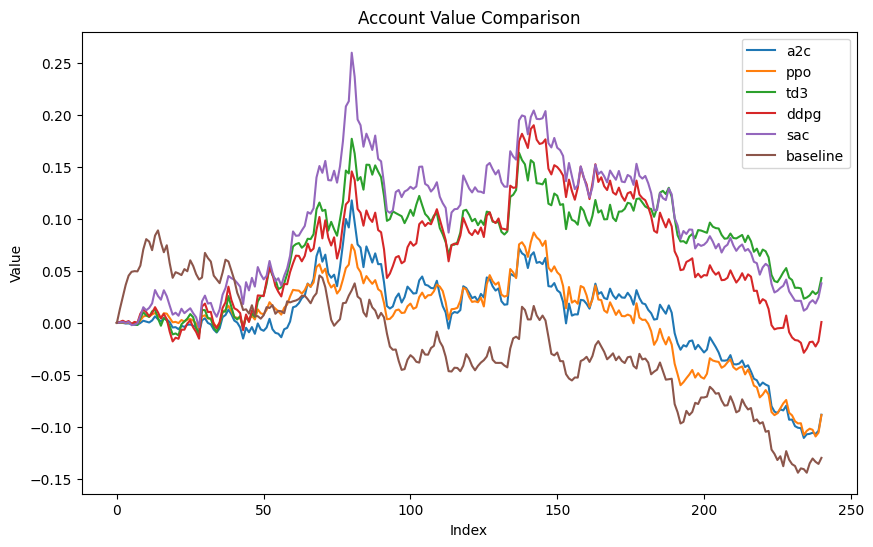

In [27]:
plt.figure(figsize=(10, 6))
for col in result_account_value.columns:
    plt.plot(result_account_value.index, result_account_value[col], label=col)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Account Value Comparison')
plt.legend()
plt.show()

## 展示回测结果

In [28]:
print("和 {} 指数进行比较".format(config.SSE_50_INDEX[0]))
cmp_data = backtest_plot_from_file(baseline_csv_file, get_baseline_func, 
                        account_value_dict,
                        value_col_name = 'total_assets')
df = pd.DataFrame(cmp_data).T
df

和 000016.SH 指数进行比较


,累计收益率,最大回撤率,年化收益率,年化波动率,Sharpe比率,Omega比率
baseline,-11.30%,-21.43%,-11.74%,12.97%,-90.50%,86.37%
a2c,-8.84%,-20.46%,-9.23%,13.56%,-68.05%,89.29%
ppo,-8.87%,-18.07%,-9.26%,12.13%,-76.32%,88.13%
td3,4.32%,-13.08%,4.52%,13.94%,32.41%,106.89%
ddpg,0.08%,-18.41%,0.09%,15.85%,0.55%,101.41%
sac,3.81%,-19.71%,3.98%,16.24%,24.54%,105.66%
